# Manipulating (Sub)Millimeter Wavelength Spectral Line Datasets

As we start on the next phase, the first step is to gain some familiarity with the kinds of data we're working with.  The basic data product is a position-position-velocity "cube", a map of emission from a spectral line as a function of the 2D position on the sky at a sequence of velocities (or frequencies).  

First, an aside on where the emission comes from.  The emission mechanism here is analogous to the standard quantum mechanics example for a hydrogen atom.  We will primarily consider simple diatomic molecules like carbon monoxide (CO).  The rotational energy states of such a molecule's center of mass are quantized: transitions between discrete energy states (from higher to lower) result in the emission of photons.  For CO, the photon energies from these "pure rotational transitions" correspond to integer multiples of the ground-state energy: for example, emission from the $J$=1$-$0 transition has a rest frequency of 115.258 GHz, $J$=2$-$1 at 230.538 GHz, $J$=3$-$2 at 345.796 GHz, etc.  These correspond to wavelengths ($\lambda = c / \nu$) of 2.6, 1.3, 0.87 mm, respectively.  

The best way to learn is to start with a data cube.  Let's download one from one of my previous projects.  These are observations of the CO $J$=2$-$1 emission line from a nearby disk:

In [1]:
import os, sys
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

# filename of interest
file = 'HD163296_CO.fits'

# download site
site = 'https://bulk.cv.nrao.edu/almadata/lp/DSHARP/images/'

# grab file (1.6 GB)
# urllib.request.urlretrieve(site+file, file)

A '.fits' file is a common image format used in astronomy.  The astropy package has some easy-to-use functionality for accessing its contents:

In [2]:
# load the cube and "header" information
data = fits.open('../' +file)
cube = np.squeeze(data[0].data)
hdr = data[0].header

# cube shape
print(cube.shape)

(105, 2000, 2000)


The cube is a 3-D array.  The first dimension is velocity, where the emission distribution is broken down into 105 distinct velocities, known as "channels" (for the same reason your TV or radio has channels, actually).  The other two dimensions are spatial "pixel" coordinates, one being the "right ascension" (RA) -- equivalent to longitude on the "celestial sphere" (the projection of the sky up from the Earth) -- and "declination" (DEC) -- equivalent to latitude.  The same spatial coordinates are present for each velocity channel.  We can convert between pixel and channel indices and actual physical coordinate values using information in the .fits header (which is a python dictionary):  

In [3]:
# SPATIAL
# number of pixels in each dimensions
nRA, nDEC = hdr['NAXIS1'], hdr['NAXIS2']

# convert pixel indices to RA, DEC (each in units of degrees on the sky)
RA = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(nRA) - (hdr['CRPIX1'] - 1))
DEC = hdr['CRVAL2'] + hdr['CDELT2'] * (np.arange(nDEC) - (hdr['CRPIX2'] - 1))

# convert these to offsets from the image center, in **arcseconds** units (1 degree = 3600 arcseconds)
RAo, DECo = 3600 * (RA - hdr['CRVAL1']), 3600 * (DEC - hdr['CRVAL2'])

# in some cases, the emission center (= location of star, which we don't see in these data) is offset from the 
# image center; we can correct for that to have a coordinate frame on the sky, centered on the star position
# (note: these shifts are quite small in this case, but for clarity, here's how you do it)
offRA, offDEC = -0.02, 0.00    # the offsets (measured elsewhere)
dRAo, dDECo = RAo - offRA, DECo - offDEC

# now create a 2-D grid of RA and DEC offsets (relative to emission center) for each pixel in the cube
dRA, dDEC = np.meshgrid(dRAo, dDECo)

# SPECTRAL
# number of channels
nchan = hdr['NAXIS3']

# convert channel indices to frequencies (in units of Hz)
freq = hdr['CRVAL3'] + hdr['CDELT3'] * (np.arange(nchan) - (hdr['CRPIX3'] - 1))

# use the Doppler formula to calculate the corresponding velocities (in units of km/s)
c_ = 2.99792e5       # speed of light in km/s
freq0 = 230.538e9    # rest frequency of CO J=2-1 line in Hz
vel = c_ * (1. - freq / freq0)

Ok, so now we can plot an image from the cube with the proper coordinates.  We call this spectral slice of the cube a "channel map", the spatial distribution of the emission from a given velocity:

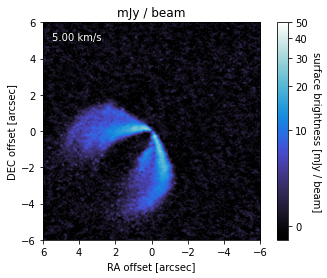

In [4]:
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize, LinearStretch)    # image visualization functions

# channel index to plot
ch_idx = 50

# define the full image boundaries with a list of the min/max RA and DEC offsets
# (note the reverse ordering for RA, since this is plotted with E to the left)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [6, -6]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-6, 6]

# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -1, 50   # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(1e3*cube[ch_idx,:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('mJy / beam')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# annotate with the velocity
vel_str = '%.2f km/s' % vel[ch_idx]
ax.text(5.5, 5.0, vel_str, color='w');

The surface brightness units here are mJy / beam, or "milliJansky per beam".  The native units of .fits files for ALMA data are Jy / beam.  The "Jansky" is a common unit in radio astronomy, where 1 Jy = 10$^{-23}$ ergs / s / cm$^2$ / Hz.  The "per beam" part is also common, but it's super confusing even to astronomers.  The "beam" is a measure of the spatial resolution of the observations: it tells you how light from a point source (i.e., a source with infinitesimally small size) would be smeared out by the instrument.  Sometimes a beam is called a "point spread function" for that same reason.  As you'll learn more about later, this "beam" is a 2-D elliptical Gaussian distribution, so the "per beam" designation is the effective area of that 2-D Gaussian.  If this elliptical beam has a full-width-at-half-maximum (FWHM) major axis of $a$ and a FWHM minor axis of $b$, the beam area being referenced is:

$\Omega_{\rm beam} = \frac{\pi \, a \, b}{4 \, \ln{2}}$.

Normally we can access the values of $a$ and $b$ from the .fits header, but for esoteric reasons this particular file is missing them.  In this case, $a = 0.104$ arcseconds (denoted $^{\prime\prime}$) and $b = 0.095^{\prime\prime}$.  So the beam area is $\Omega_{\rm beam} = 0.011$ arcseconds$^2$.

Frequently, radio astronomers instead choose to quote surface brightnesses $I_\nu$ (as above) in a different format.  Then, we speak of "brightness temperatures", $T_b$.  In the most formal sense, $T_b$ is the temperature that matches the surface brightness so that $I_\nu = B_\nu(T_b)$, where $B_\nu$ is the Planck function.  But in common usage, we assume the Rayleigh-Jeans limit applies (technically it doesn't!), so that 

$I_\nu = \frac{2 \, k_B \, \nu^2 \, T_b}{c^2}$

where $\nu$ is the frequency, $k_B$ is the Boltzmann constant, and $c$ is the speed of light.  The conversion seems straightforward, but the units _often_ thwart people.  The key is to convert $I_\nu$ into CGS units, noting that the appropriate unit for an area on the sky (i.e., the beam area) is _steradians_, or square radians (rather than square arcseconds).  Its useful to be facile with this brightness convention transformation.  Write a function to do it:

In [6]:
sys.path.append('/Users/justinvega/Documents/GitHub/dyn-masses/fit_Mdyn/')
from brighttemp import brighttemp

print(brighttemp(-0.001, (0.104, 0.095), 230.538e9))
print(brighttemp(0.05, (0.104, 0.095), 230.538e9))

-2.3273980152834475
116.36990076417239


Now plot the same channel map as above, but on a $T_b$ scale instead of a mJy / beam scale:

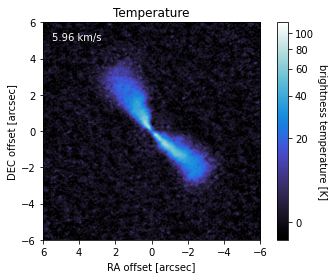

In [7]:
ch_idx=53

# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -3, 117   # these are in K units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(brighttemp(cube[ch_idx,:,:], (0.104, 0.095), 230.538e9), origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Temperature')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('brightness temperature [K]', rotation=270, labelpad=13)

# annotate with the velocity
vel_str = '%.2f km/s' % vel[ch_idx]
ax.text(5.5, 5.0, vel_str, color='w');

# print(brighttemp(cube[ch_idx,:,:], (0.104, 0.095), 230.538e9).min())
# print(brighttemp(cube[ch_idx,:,:], (0.104, 0.095), 230.538e9).max())

The full data cube includes a large number of channels in the typical case.  Here, we have 105.  Usually we want to look at all of them together on a grid, since that reveals important information about the disk kinematics.  Make a set of 100 channel maps in a 10x10 grid.  You can plot them all on the same brightness scale, so the scalebar isn't necessary (for now).  This should be coded in a loop, and I'd strongly recommend you use the matplotlib.gridspec functionality.

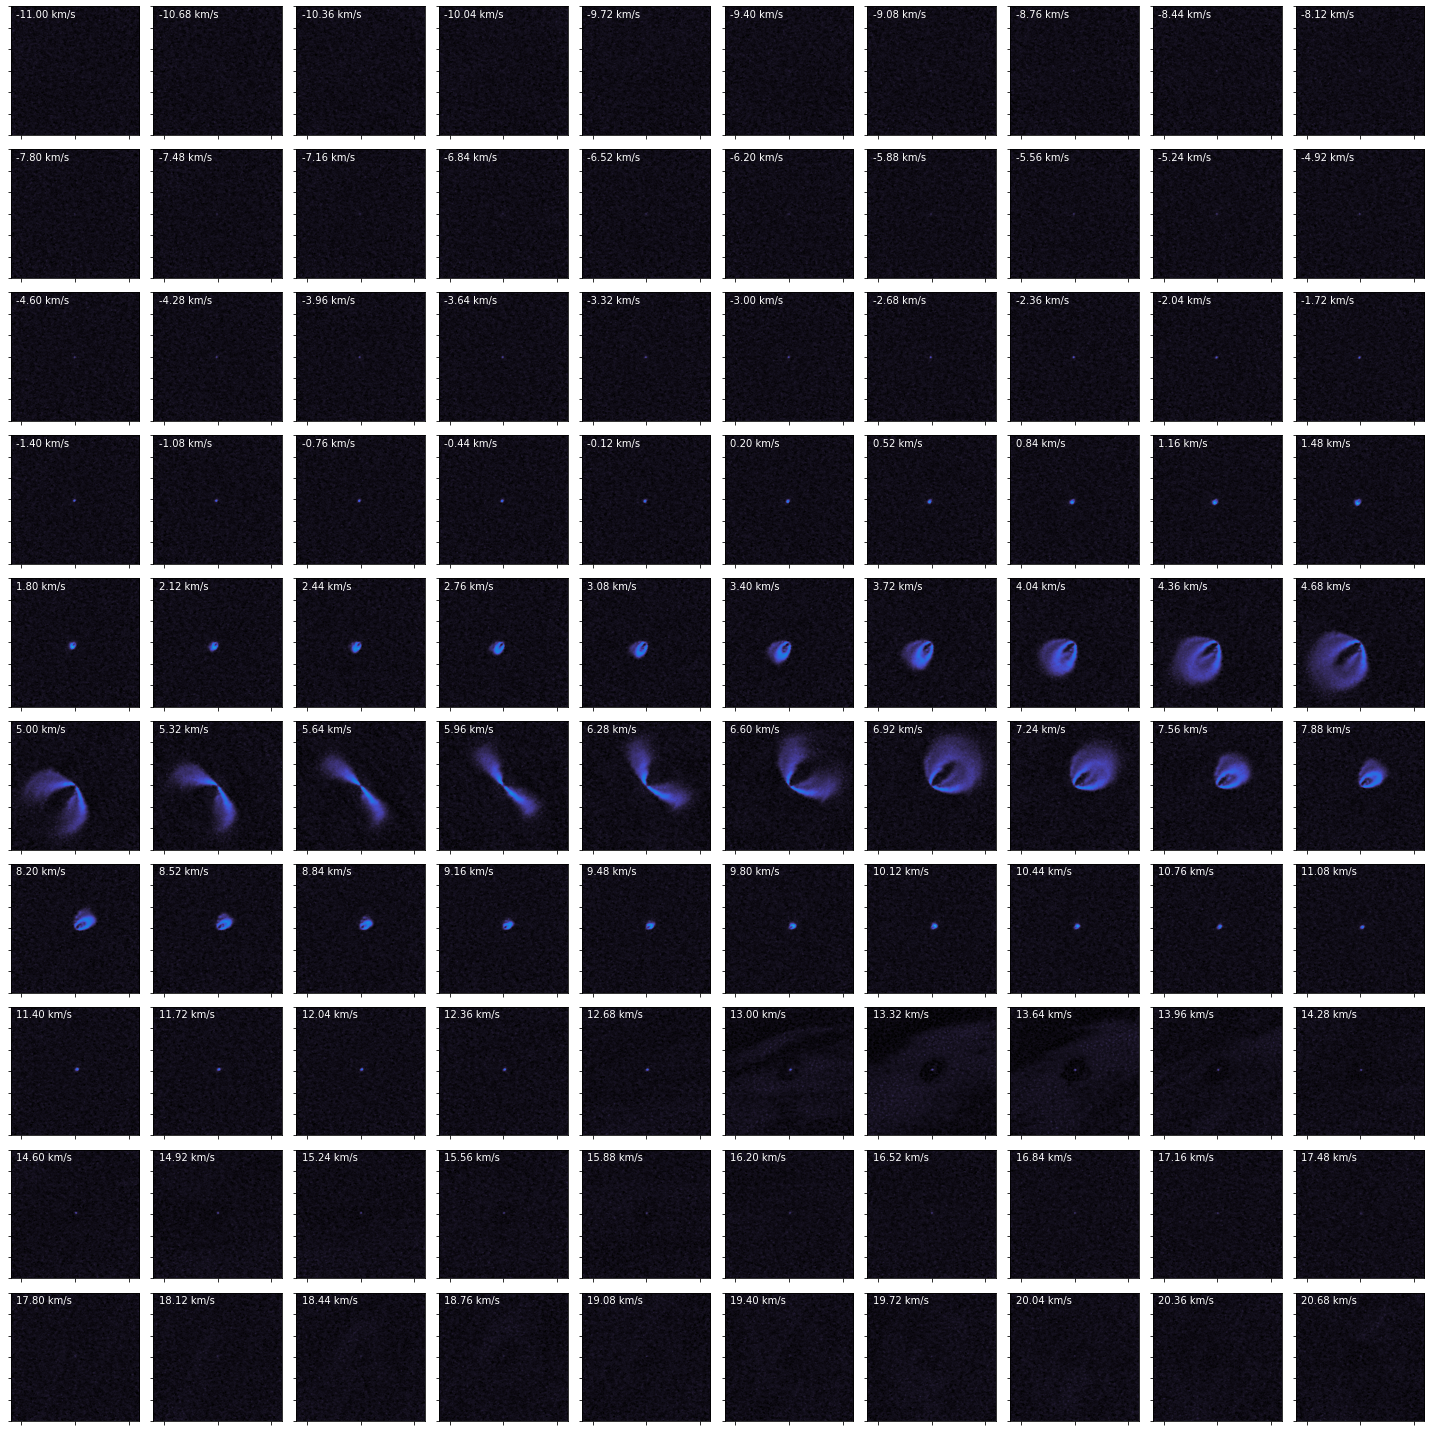

In [7]:
import matplotlib.gridspec as gridspec

n=10
axes = ['ax'+ str(i) for i in range(n**2)]
vch_idx = np.arange(100)

c = np.arange(n)
r = np.arange(n)
cols, rows = np.meshgrid(c, r)
points = np.column_stack((np.ravel(rows), np.ravel(cols)))

# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -3, 117   # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

fig = plt.figure(tight_layout=True, figsize=(20,20))
spec = gridspec.GridSpec(ncols=n, nrows=n, figure=fig)
        
for i in range(len(axes)):  
    axes[i] = fig.add_subplot(spec[points[i][0], points[i][1]])
    axes[i].imshow(1e3*cube[vch_idx[i],:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
    axes[i].set_xlim(dRA_lims)
    axes[i].set_ylim(dDEC_lims)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)        
    
    # annotate with the velocity
    vel_str = '%.2f km/s' % vel[vch_idx[i]]
    axes[i].text(5.5, 5.0, vel_str, color='w');

Try to digest some of the "patterns" you see in these channel maps.  How are the general spatial and kinematic (spectral) variations in the emission related?

In [8]:
#To save images:
# for i in range(len(axes)):  
#     fig, ax = plt.subplots()
#     ax.imshow(1e3*cube[ch_idx[i],:,:], origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
#     ax.set_xlim(dRA_lims)
#     ax.set_ylim(dDEC_lims)
#     plt.setp(ax.get_xticklabels(), visible=False)
#     plt.setp(ax.get_yticklabels(), visible=False)        
#     # annotate with the velocity
#     vel_str = '%.2f km/s' % vel[ch_idx[i]]
#     ax.text(5.5, 5.0, vel_str, color='w');
#     fig.savefig('image%s.png' % i, bbox_inches='tight')

### Condensed Metrics

In many cases, users will _condense_ the 3-D spectral line cube into a variety of other metrics that aid in visualizing and interpreting such data.  There are a lot of ways to do this, but let's run through how the most common ones work.

**(1) Spatially-integrated spectrum:** Maybe the most straightforward option is to plot the spatially-integrated spectrum of the cube.  This means simply summing the emission in each channel map, and plot the _flux_ as a function of velocity.  The _flux_ is defined in Jy units, so you need to count up the number of beam areas that you include in the sum for any individual channel (where recall the units are Jy/beam).  The key issue to consider then is what _aperture_ you'll integrate over in each channel....i.e., which pixels you'll include in the sum.  A simple approach is to just choose some rectangle that encapsulates all the emission in all the channels.  A slightly more sophisticated approach would be to define a _clip_, or threshold, where you only sum pixels brighter than some value (usually chosen to be ~2-3x the RMS noise level, which you could estimate in emission-free regions of the cube).

In [9]:
#find noise (roughly ~0.007 = 7 mJy/beam)
noise = 3*np.nanstd(cube[:,0:5,:])
print(noise)

0.0071740353014320135


In [10]:
ch_indx = np.arange(105)

sum_sb = np.full_like(cube[50,:,:], 0)
sum_sbvel = np.full_like(cube[50,:,:], 0)
nonzero_count = 0

for i in range(len(ch_indx)):
    channel = cube[ch_indx[i]]
    channel[channel < noise] = 0 #clip = channel < noise  # Where values are low
    nonzero_count += np.count_nonzero(channel) # how many values are less than 0?
    sum_sb = np.add(sum_sb, channel)
    sbv = channel*vel[i]
    sum_sbvel = np.add(sum_sbvel, sbv)

In [11]:
frac = 1-(nonzero_count/(2000*2000*105)) # fraction of pixels that are not zero (~0.5)
SI_area = np.pi*0.104*0.095/(4*np.log(2)) # area of one beam (0.011)

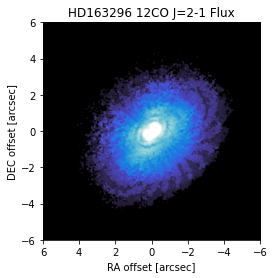

In [20]:
# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = 0, 2e-3   # these are in Jy units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

flux = SI_area*sum_sb*frac
fig, ax = plt.subplots()
ax.imshow(flux, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_title('HD163296 12CO J=2-1 Flux')
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# # add a scalebar
# cb = plt.colorbar(im, ax=ax, pad=0.05, format='%.1e')
# cb.set_label('Flux [Jy]', rotation=270, labelpad=13)
plt.savefig("HD163296 flux.jpg", dpi=300)

**(2) Moment maps:** The most common things we find in the literature are called moment maps.  They're defined in a familiar way for many with a physics / mathematics background.

A moment$-0$ map, $M_0$, is the velocity-integrated intensity of the cube, with units of Jy km/s / beam,

$M_0 = \delta V \, \sum_i I_i$,

where $i$ indexes the channels, and $\Delta V$ is the channel-spacing in velocity units.

A moment$-1$ map, $M_1$, shows the intensity-weighted velocities in the cube, with units of km/s,

$M_1 = \frac{1}{M_0} \sum_i I_i \, V_i$,

where $V_i$ is the velocity of each channel.  Usually moment$-1$ maps are shown on a diverging color scale (often with an appropriate red/blue pattern corresponding to redshifted and blueshifted sides of the disk).  This is sort of like a map of the (projected) disk rotation, in our particular case.

A moment$-2$ map, $M_2$, is the intensity-weighted velocity dispersion in the cube, with units of km/s,

$M_2 = \sqrt{\frac{\sum_i I_i \, (V_i - M_1)^2}{M_0}}$,

and is usually treated as a metric for the spatial distribution of the spectral line-widths.

In all of these cases, the question of which pixels to include (or exclude) again becomes important.  Experiment with clips to see how they work in these cases.

In [13]:
import bettermoments.collapse_cube as bm
asw = bm.collapse_zeroth(vel, cube, noise)[0]

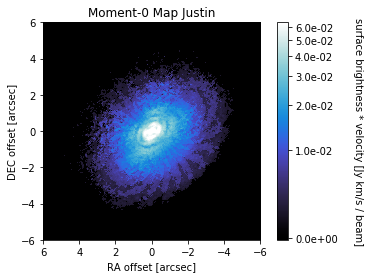

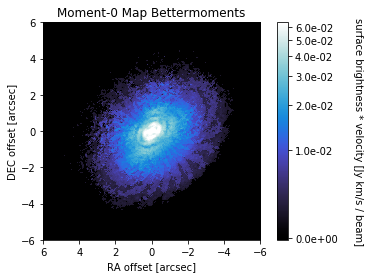

In [14]:
# Moment-0 map
dv = vel[2]-vel[1] # in km/s; ~0.32 km/s

# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = -dv*5e-4, dv*0.2   # these are in Jy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
m0 = sum_sb*dv
im = ax.imshow(m0, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Moment-0 Map Justin')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05, format='%.1e')
cb.set_label('surface brightness * velocity [Jy km/s / beam]', rotation=270, labelpad=25)

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
m0 = sum_sb*dv
im = ax.imshow(asw, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Moment-0 Map Bettermoments')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05, format='%.1e')
cb.set_label('surface brightness * velocity [Jy km/s / beam]', rotation=270, labelpad=25)

In [15]:
#Cross check with bettermoments: good
print(np.nanmax(m0))
print(np.nanmin(m0))
print(np.nanmax(asw))
print(np.nanmin(asw))

0.13287216
0.0
0.13287216
0.0


In [16]:
rad = bm.collapse_first(vel, cube, noise)[0]

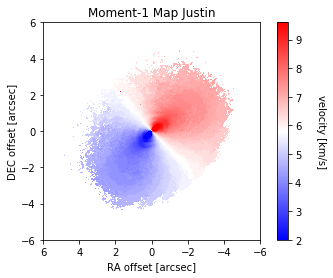

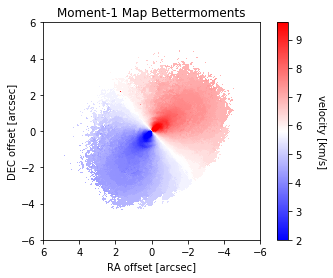

In [17]:
# Moment-1 map
import matplotlib as mpl

# now define the color-map, intensity limits, and stretch
cmap = 'bwr'
vmin, vmax = 2, 9.6
norm = mpl.colors.Normalize(vmin=2,vmax=9.6) # these are in m/s units, 

np.seterr(divide='ignore', invalid='ignore')
m1 = (sum_sbvel*dv)/m0

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(m1, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Moment-1 Map Justin')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('velocity [km/s]', rotation=270, labelpad=25)

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(rad, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Moment-1 Map Bettermoments')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('velocity [km/s]', rotation=270, labelpad=25)

In [18]:
# Cross check with bettermoments: good
print(np.nanmax(rad)) #differs by 1/dv
print(np.nanmin(rad))
print(np.nanmax(m1)) #dv accounted for in m1 calculation
print(np.nanmin(m1)) 

22.279959577303696
-10.999977268868626
22.279968
-10.999984


In [19]:
asdf = bm.collapse_second(vel, cube, noise)[0]

In [20]:
# Moment-2 map
m2_calc = np.full_like(cube[50,:,:], 0) #array that stores summation part of m2

for i in range(len(ch_indx)):
    sb = cube[ch_indx[i]]
    sb[sb < noise] = 0
    m2_top = sb * (vel[i]-(m1))**2 #numerator of m2 expression
    m2_calc = np.add(m2_calc, m2_top) #creates a sum of m2_top over all channel indices

m2 = np.sqrt(m2_calc/sum_sb)

In [21]:
#Cross check with bettermoments: good
print(np.nanmax(m2))
print(np.nanmin(m2))
print(np.nanmax(asdf))
print(np.nanmin(asdf))

16.477262
0.0
16.477260601192278
0.004955394447217065


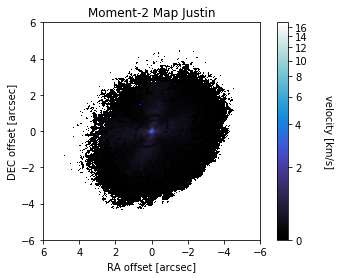

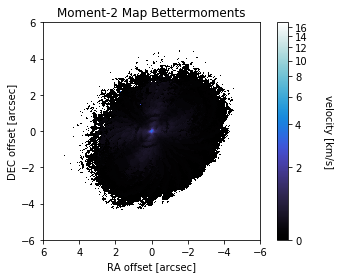

In [22]:
# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = 0, 17   # these are in Jy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(m2, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Moment-2 Map Justin')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('velocity [km/s]', rotation=270, labelpad=25)

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(asdf, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
ax.set_title('Moment-2 Map Bettermoments')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('velocity [km/s]', rotation=270, labelpad=25)

**(3) Peak brightness map:** One related metric is the peak brightness (sometimes called moment$-8$) map, which shows the spatial distribution of the spectral peak (maximum) in each pixel, usually in brightness temperature (K) units.  

In [23]:
wazu = bm.collapse_eighth(vel, brighttemp(cube, (0.104, 0.095), 230.538e9), noise)[0]

In [24]:
m8jansky = np.amax(cube, axis=0)
m8jansky[m8jansky < noise] = 0
m8 = brighttemp(m8jansky, (0.104, 0.095), 230.538e9)

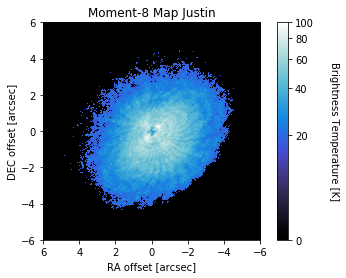

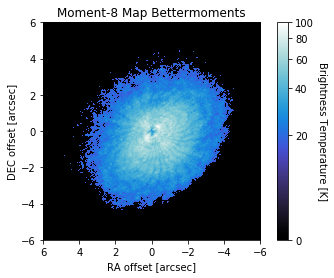

In [25]:
# now define the color-map, intensity limits, and stretch
cmap = cmr.freeze
vmin, vmax = 0, 100   # these are in Kelvin units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(m8, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')
#ax.set_title('Moment-8 Map Justin')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('Brightness Temperature [K]', rotation=270, labelpad=25)

plt.savefig("Moment 8 Map.png", dpi=300)
# # set up and plot the image on the specified scale
# fig, ax = plt.subplots()
# im = ax.imshow(wazu, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
# ax.set_xlim(dRA_lims)
# ax.set_ylim(dDEC_lims)
# ax.set_xlabel('RA offset [arcsec]')
# ax.set_ylabel('DEC offset [arcsec]')
# ax.set_title('Moment-8 Map Bettermoments')

# # add a scalebar
# cb = plt.colorbar(im, ax=ax, pad=0.05)
# cb.set_label('Brightness Temperature [K]', rotation=270, labelpad=13)

In [26]:
print(np.nanmax(m8))
print(np.nanmin(m8))
print(np.nanmax(wazu))
print(np.nanmin(wazu))

94.82468
0.0
94.82468
0.0


When you've played around with these moment maps, you should install and experiment with the [${\tt bettermoments}$ code](https://github.com/richteague/bettermoments) from postdoctoral fellow Dr. Rich Teague (our collaborator).  Compare the moment maps generated from this code with your own.  

**(4) Position-Velocity diagram:** This one is a little trickier to code, but it is probably most closely connected to getting a rough estimate of the stellar mass.  Take a look at the moment$-0$ maps you've made.  You want to isolate a "cut" (a line with some thickness) along the major (long) axis of the integrated emission that intersects with the disk center.  For each pixel in that cut, you have a projected distance from the center (in arcseconds) and a spectrum (the brightness as a function of velocity).  You want to make a plot of that spectrum at each "position" (distance).  Take a look at Figure 8 in [this paper](https://iopscience.iop.org/article/10.3847/2041-8213/aaf747/pdf) (these are the same data you're using now) for an example.  The edges of those position-velocity curves are related to the (projected) Keplerian velocities of the gas (blue lines in that figure).  You can make this with a few pieces of information:

- The distance in arcseconds can be converted to a projected distance in astronomical units (AU = earth-sun distance, or 1.496e13 cm) by multiplying by the distance in parsecs (pc = 3.09e18 cm).  

- The Keplerian velocity field of a disk is $V_{\rm Kep} = \sqrt{\frac{G \, M_\ast}{r^3}}$, where $G$ is Newton's constant (6.67e-8), $M_\ast$ is the stellar mass in grams, and $r$ is the distance in cm (so $V$ will be in cm/s units).

- The projected velocity field is $V_{\rm Kep} \sin{i}$, where $i$ is the inclination (tilt) of the disk relative to the sky plane.  For the HD 163296 disk, $i = 47$ degrees.

Those blue curves are just plots of $V_{\rm Kep} \sin{i}$: estimate an appropriate $M_\ast$ for this case using your position-velocity diagram (note that solar mass units are $M_\odot = 1.989e33$ g).  

In [27]:
# skip

## Gofish

# Basics of `GoFish`

This Notebook will walk through the very basic steps of how to load up data, set up the rotation profile and start extracting spectra.


## Load the Data

Loading the data is as simple as firing up `GoFish` and passing it the path of the fits cube to `imagecube`.

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gofish import imagecube

In [11]:
file = 'HD163296_CO.fits'
cube = imagecube('../' +file, FOV=4.0)

You can use the `FOV` argument here to trim down your image cube to a field of view which may speed up calculations.

## Coordinate System

We can deproject from a pixel position, $(x_{\rm pix},\, y_{\rm pix})$, to a disk-frame coordinate, $(r,\,\theta)$. These transforms are done through the `imagecube.disk_coords` function which takes geometrical properties of the disk and returns the disk coordinates.

For the CO $J$=2$-$1 emission of HD163296, we know that the inclination `i=46.7` and `PA=132.8` (both in degrees), so we can return the $(r,\,\theta)$ values for each pixel. We also assume the source is centered in the image such that `x0=0.0` and `y0=0.0`.

In [13]:
inc = 46.7 #degrees
PA = 133.3
rvals, tvals, _ = cube.disk_coords(x0=0.0, y0=0.0, inc=inc, PA=PA)

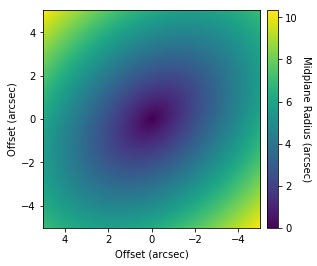

In [31]:
fig, ax = plt.subplots()
im = ax.imshow(rvals, origin='lower', extent=cube.extent, vmin=0.0)
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Midplane Radius (arcsec)', rotation=270, labelpad=13)

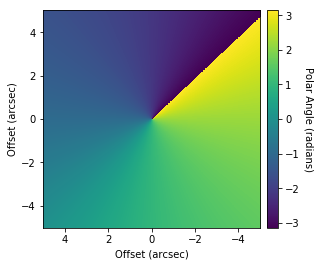

In [32]:
fig, ax = plt.subplots()
im = ax.imshow(tvals, origin='lower', extent=cube.extent)
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Polar Angle (radians)', rotation=270, labelpad=13)

The polar angle, $\theta$, in is radians, and runs from $-\pi$ to $\pi$ in an eastward direction with $\theta = 0$ aligning with the red-shifted major axis of the disk. Note that this is _not_ the same as the position angle, particualrly when the disk is highly inclined.

You'll notice that when calling `disk_coords` we left space for three returned parameters. The third is $z$, the height above the midplane. By default, we assume that the disk is a razor-thin 2D disk. However, with the high spatial resolution afford by ALMA, it is now possible to resolve the vertical structure of the disk as well (see [Rosenfeld et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...774...16R) for a nice demonstration of this for HD 163296).

For this, we assume that the emission surface is described via,

$$
z(r) = z_0 \times \left( \frac{r}{1^{\prime\prime}} \right)^{\psi} + z_1 \times \left( \frac{r}{1^{\prime\prime}} \right)^{\varphi}
$$

where the second term acts as a 'correction' term in order to account for the drop in emission surface expected due to the drop in gas surface density at large radii. `disk_coords` also accepts the parameters `z0, psi, z1, phi` to describe the emission height. If we take `psi=1.0`, we recover a conical disk, while `psi > 1.0` gives a flared disk surface.

As an example, we increase the inclination to make the changes due to the height more noticable.

In [33]:
rvals, tvals, zvals = cube.disk_coords(inc=inc, PA=PA, z0=0.3, psi=1.0)

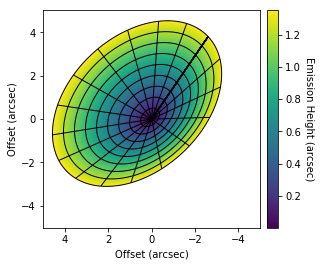

In [34]:
fig, ax = plt.subplots()
im = ax.imshow(np.where(rvals <= 4.5, zvals, np.nan), origin='lower', extent=cube.extent)
ax.contour(cube.xaxis, cube.yaxis, rvals, np.arange(0.5, 5.0, 0.5), linewidths=1.0, colors='k')
ax.contour(cube.xaxis, cube.yaxis, np.where(rvals <= 4.5, tvals, np.nan),
           np.linspace(-np.pi, np.pi, 18)[:-1], linewidths=1.0, linestyles='-', colors='k')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Emission Height (arcsec)', rotation=270, labelpad=13)

Note that in the above we've done some clipping to the arrays to make it look neater, although the arrays will span the entire field of view of the cube.

We can also assume the disk is rotated in the opposite direction by flipping the sign of the inclination.

In [35]:
rvals, tvals, zvals = cube.disk_coords(inc=-inc, PA=PA, z0=0.3, psi=1.0)

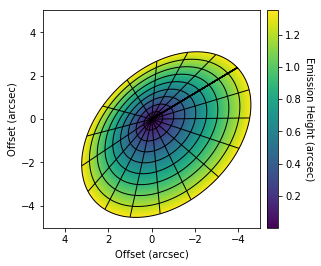

In [36]:
fig, ax = plt.subplots()
im = ax.imshow(np.where(rvals <= 4.5, zvals, np.nan), origin='lower', extent=cube.extent)
ax.contour(cube.xaxis, cube.yaxis, rvals, np.arange(0.5, 5.0, 0.5), linewidths=1.0, colors='k')
ax.contour(cube.xaxis, cube.yaxis, np.where(rvals <= 4.5, tvals, np.nan),
           np.linspace(-np.pi, np.pi, 18)[:-1], linewidths=1.0, linestyles='-', colors='k')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Emission Height (arcsec)', rotation=270, labelpad=13)

## Extracing a Disk Averaged Spectrum

Now that we know how to deproject the data, we can use this to map a Keplerian velocity field onto the disk and calculated the projected line of sight velocity, $v_0$, given by,

$$
v_0(r,\,\theta) = \sqrt{\frac{GM_{\rm star}r^2}{(r^2 + z^2)^{3/2}}} \, \cos (\theta) \, \sin (i),
$$

where we are expected to know $M_{\rm star}$ ($2.0~M_{\rm sun}$ for HD163296), and the distance to the source ($101~{\rm pc}$).

To apply this we use the `averaged_spectrum` function, which is provided the geometrical properties of the disk to calculate $v_0$, before applying these shifts to concentric annuli of the data before combining them, weighted by the area of each annulus. We must also tell it what radial range to consider through the `r_min` and `r_max` parameters, both given in arcseconds.

In [15]:
mstar = 2.05
dist = 101.0
x, y, dy = cube.average_spectrum(r_min=0, r_max=2.0, inc=inc,
                                 PA=PA, mstar=mstar, dist=dist)

Notice the warning above, ``WARNING: Setting `r_min = cube.dpix` for safety.``. This is because we get a singularity at $r = 0$. If you really want to push in as close to the disk center as possible, try `r_min=1e-4`, but be warned, beam convolution effects limit the accuracy of this method in regions closer in than a beam FWHM.

Plotting the data gives a nice spectrum:

Text(0, 0.5, 'Flux Density (Jy/beam)')

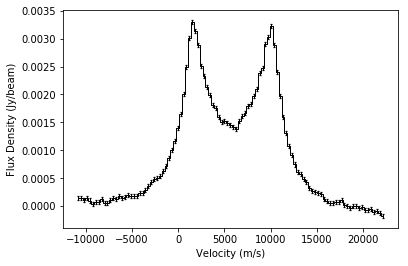

In [38]:
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
#ax.set_xlim(9e3, 1.3e4)

Note also that by default `dy` is the standard deviation of the samples in the velocity bin (calculated by calling for the standard deviation of the bin with `scipy.stats.binned_statistics`), rather than the uncertainty on the flux density. This is because the binned data is not strictly independent owing to both small spectral and spatial correlations in the data.

Assuming that the data is indeed uncorrelated (not a toally unreasonable assumption), the uncertainty on the flux density can be estimated through

\begin{equation}
\delta y \approx \sigma_{\rm bin} \, \sqrt{\frac{\Delta V_{\rm chan} }{N_{\rm spectra} \,\Delta V_{\rm bin}}},
\end{equation}

where $N_{\rm spectra}$ is the number of spatially independent spectra used in each bin.

By using `assumed_correlated=False` in the call, we can return an estimate of the uncertainty of the flux density.

Text(0, 0.5, 'Flux Density (Jy/beam)')

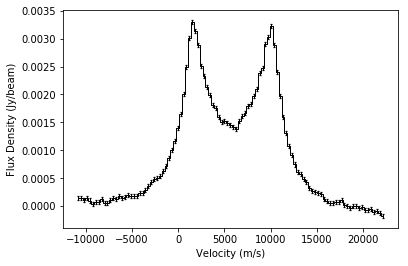

In [39]:
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=2.0, inc=inc,
                                 PA=PA, mstar=mstar, dist=dist,
                                 assume_correlated=False)

fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
#ax.set_xlim(1.84e3, 3.84e3)

This you can see is a slightly smaller value. For a higher resolution cube, the number of independent spectra will increase and thus the uncertainty on the flux density will decrease.

Because we end up sampling the line profile at a much higher rate thanks to the Doppler shift of the lines around the azimuth (see the discussion in [Teague et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/)), we can resample at a higher rate. This is done through the `resample` parameter. By default this is `resample=1`, so returns the velocity axis attached to the cube.

If the argument is an `int`, then we super-sample by that factor, while if it is a `float`, then that is the channel spacing. For example:

Text(0, 0.5, 'Flux Density (Jy/beam)')

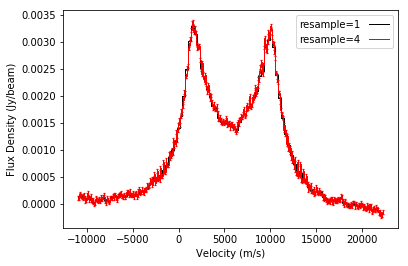

In [40]:
fig, ax = plt.subplots()

# Integeter
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=2.0, inc=inc, PA=PA,
                                 mstar=mstar, dist=dist, dr=0.1, resample=1,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0, label='resample=1')

# Float
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=2.0, inc=inc, PA=PA,
                                 mstar=mstar, dist=dist, dr=0.1, resample=4,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='r', lw=1.0)
ax.step(x, y, where='mid', color='r', lw=1.0, label='resample=4')

ax.legend(loc=1, markerfirst=False)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
#ax.set_xlim(2.54e3, 3.14e3)

Similarlaly, we can use down-sample the velocity axis if we want to improve the SNR of the detection.

36.700345039367676


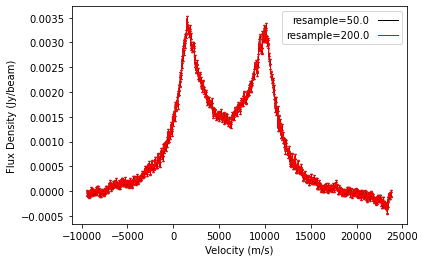

In [16]:
import time
t0 = time.time()

fig, ax = plt.subplots()

# Integeter
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=2.0, inc=inc, PA=PA,
                                 mstar=mstar, dist=dist, dr=0.1, resample=50.0,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0, label='resample=50.0')

# Float
x, y, dy = cube.average_spectrum(r_min=0.0, r_max=2.0, inc=inc, PA=PA,
                                 mstar=mstar, dist=dist, dr=0.1, resample=50.0,
                                 assume_correlated=False)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='r', lw=1.0)
ax.step(x, y, where='mid', color='r', lw=1.0, label='resample=200.0')

ax.legend(loc=1, markerfirst=False)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Flux Density (Jy/beam)')
#ax.set_xlim(2.34e3, 3.34e3)
t1 = time.time()
print(t1-t0)

____

**Quick Aside:** By binning the data to lower spectral resolutions you are actually losing information, even though it may appear to improve things. If you know that your line profile is Gaussian, you'll get the best results when fitting a Gaussian line when you have the highest spectral sampling. See, for example [Lenz & Ayres (1992)](https://ui.adsabs.harvard.edu/abs/1992PASP..104.1104L/).

____

Using the argument `unit='K'`, we can also return this in units of Kelvin, using the Rayleigh-Jeans approximation. And note it is exactly that, an approximation, and is a very poor conversion at sub-mm wavelengths, so use with caution! It does, however, offer a quick way to compare spectra _of the same frequency_, but imaged at different beam sizes.

## Extracted a Disk Integrated Spectrum

In a very similar fashion we can extract a disk integrated spectrum, returning a spectrum in units of Jansky. Again we provide it the inner and outer radii to integrate over.

Text(0, 0.5, 'Integrated Flux (Jy)')

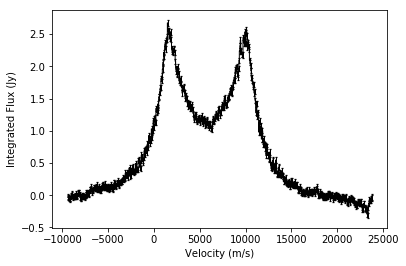

In [42]:
fig, ax = plt.subplots()
x, y, dy = cube.integrated_spectrum(r_min=0.0, r_max=2.0, inc=inc, PA=PA,
                                 mstar=mstar, dist=dist, dr=0.1, resample=50.0)
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Integrated Flux (Jy)')
#ax.set_xlim(1.84e3, 3.84e3)

## Radial Profiles

For well detected sources, you can also imaging wanting to plot radial profiles of their emission. Most typically people would plot the radial profile of the total integrated intensity, showing ${\rm Jy\,beam^{-1}\,km\,s^{-1}}$ as a function of radius, or the peak flux density, ${\rm Jy\,beam^{-1}}$, or the brightness temperature, ${\rm K}$, as a function of radius.

Most of the time this can be readily achieved by making moment maps (shameless plug for [`bettermoments`](https://github.com/richteague/bettermoments) to make such moment maps) and creating the radial profiles. However, even for bright sources, in the outer disk this approach is limited to what can be detected on a _per pixel_ basis. Shifting and stacking the spectra and give a significant improvement in the outer disk.

The easiest way to get a profile is to use the `radial_profile` function. As with the `averaged_spectrum` or `integrated_spectrum` you want to specify the source geometry. In addition, you can (should!) provide radial bin edges or centers (not both) and the unit you want. The allowed `unit` values are:

- ``'Jy m/s'``: Integrated spectrum in Janskys.
- ``'K m/s'``: Integrated spectrum in Kelvin.
- ``'Jy'``: Peak of the integrated spectrum.
- ``'Jy/beam'``: Peak of the averaged spectrum.
- ``'K'``: Peak of the averaged spectrum in Kelvin.

In [43]:
t0 = time.time()
# Calculate the peak flux density as a function of radius.
x, y, dy = cube.radial_profile(inc=inc, PA=PA, mstar=mstar, dist=dist, unit='Jy/beam')
t1 = time.time()
print(t1-t0)

347.4001681804657


Text(0, 0.5, 'Peak Flux Density (Jy/beam)')

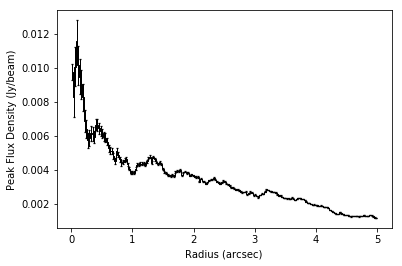

In [44]:
# Plot
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Flux Density (Jy/beam)')


For the integrated quantities, these are integrated over the _whole_ spectrum. You might want to apply your own clipping thresholds or integration ranges. If this is the case you can return an array of all the spectra using the `radial_specrta` function which takes the same values. Note this time `unit` can only be `'Jy'`, `'Jy/beam'` or `'K'`. 

In [45]:
# Get the array of spectra.
t0 = time.time()
rvals, spectra, *c = cube.radial_spectra(inc=inc, PA=PA, mstar=mstar, dist=dist, unit='Jy/beam')
t1 = time.time()
print(t1-t0)

356.40193796157837


Here `rvals` is the array of bin centers used for the profile while `spectra` is of shape `(M, 3, N)` where `M` is the number of radial samples and `N` is the number of velocity samples. The second (index 1) axis is split over velocity, flux density and uncertainty.

In [46]:
print(rvals.shape, cube.velax.shape, spectra.shape)

(192,) (105,) (105,)


A nice way to plot all these spectra is as follows which nicely demonstrates how the lines get weaker in the outer disk but also narrower. This is called a 'teardrop plot'.

19.922651767730713


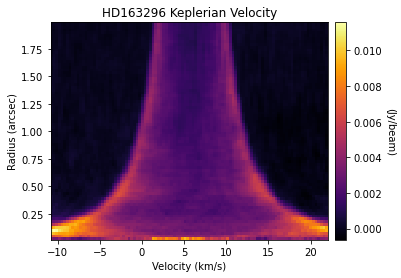

In [17]:
import time
t0 = time.time()
cube.plot_teardrop(inc=inc, PA=PA, mstar=mstar, dist=dist)
plt.title("HD163296 Keplerian Velocity")
t1 = time.time()
print(t1-t0)
#plt.savefig("teardrop plot.jpg", dpi=300)